# Random Forest Visualization

# Setup and Configuration (Run this cell first)
## Ensemble Random Forest LIME Visualizer Setup
## This cell contains all the necessary imports, classes, and configurations
## Users should run this cell once, then use the next cell for SMILES input

In [1]:

import joblib
import pandas as pd
import numpy as np
import json
import os
import io
from typing import Dict, List, Tuple, Optional
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualization imports
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from PIL import Image

# RDKit imports
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit.Chem.Draw import rdMolDraw2D

# XAI imports
from lime import lime_tabular

class EnsembleRandomForestExplainer:
    """
    Ensemble Random Forest LIME Explainer for molecular activity prediction
    
    Uses the best models selected from cross-validation results to provide
    LOCAL explanations (instance-specific) using LIME method:
    - LIME: Local Interpretable Model-agnostic Explanations for individual molecules
    
    Explains how molecular features contribute to the prediction of a SPECIFIC molecule,
    rather than global model behavior across all molecules.
    """
    
    def __init__(self, 
                 best_models_path: str = 'best_models.json',
                 model_checkpoints_dir: str = 'model_checkpoints',
                 training_data_path: str = 'SA_FG_fragments.csv',
                 fg_mapping_path: str = 'Functional_Group_mapping.txt',
                 threshold: float = 0.5):
        """
        Initialize the ensemble LIME explainer
        
        Args:
            best_models_path: Path to best_models.json file
            model_checkpoints_dir: Directory containing model checkpoints
            training_data_path: Path to training data CSV
            fg_mapping_path: Path to functional group mapping file
            threshold: Classification threshold for active/inactive
        """
        self.threshold = threshold
        self.model_checkpoints_dir = model_checkpoints_dir
        self.fg_mapping_path = fg_mapping_path
        
        print("Initializing Ensemble LIME Explainer...")
        
        # Load best models information
        self.best_models_info = self._load_best_models(best_models_path)
        print(f"Loaded information for {len(self.best_models_info)} best models")
        
        # Load training data first to get feature names
        self.training_data = pd.read_csv(training_data_path)
        self.feature_names = [col for col in self.training_data.columns if col.startswith('fr_')]
        print(f"Loaded training data with {len(self.feature_names)} features")
        
        # Load ensemble models and scalers
        self.models, self.scalers = self._load_ensemble_models()
        print(f"Successfully loaded {len(self.models)} models and scalers")
        
        # Prepare ensemble training data for LIME
        self.ensemble_training_data = self._prepare_ensemble_training_data()
        print(f"Prepared ensemble training data: {self.ensemble_training_data.shape}")
        
        # Load functional group mappings
        self.fg_mapping = self._load_fg_mapping()
        
        # Create SMARTS patterns mapping
        self.smarts_mapping = self._create_smarts_mapping()
        
        # Initialize LIME explainer
        self._initialize_lime_explainer()
        print("LIME explainer initialized")
        
        print("Ensemble LIME Explainer ready!")
        
    def _load_best_models(self, best_models_path: str) -> List[Dict]:
        """Load best models information from JSON file"""
        try:
            with open(best_models_path, 'r') as f:
                data = json.load(f)
            return data['models']
        except Exception as e:
            raise FileNotFoundError(f"Error loading best models from {best_models_path}: {str(e)}")
    
    def _load_ensemble_models(self) -> Tuple[List, List]:
        """Load all ensemble models and scalers"""
        models = []
        scalers = []
        
        for model_info in self.best_models_info:
            cv = model_info['cv']
            fold = model_info['fold']
            
            # Construct paths
            model_dir = os.path.join(self.model_checkpoints_dir, f'cv{cv}_fold{fold}')
            model_path = os.path.join(model_dir, 'model.joblib')
            scaler_path = os.path.join(model_dir, 'scaler.joblib')
            
            # Load model and scaler
            try:
                model = joblib.load(model_path)
                scaler = joblib.load(scaler_path)
                models.append(model)
                scalers.append(scaler)
                print(f"  Loaded CV{cv} Fold{fold}")
            except Exception as e:
                print(f"  Failed to load CV{cv} Fold{fold}: {str(e)}")
                continue
        
        if not models:
            raise ValueError("No models were successfully loaded!")
            
        return models, scalers
    
    def _prepare_ensemble_training_data(self) -> np.ndarray:
        """Prepare training data scaled by ensemble average - FIXED VERSION"""
        # Get training features in correct order
        X_train = self.training_data[self.training_data['group'] == 'training'][self.feature_names]
        
        # Scale with each scaler and average
        scaled_data_list = []
        for scaler in self.scalers:
            # Simply use the feature names we know are correct
            scaled_data = scaler.transform(X_train)
            scaled_data_list.append(scaled_data)
        
        # Average scaled data across all scalers
        ensemble_scaled_data = np.mean(scaled_data_list, axis=0)
        return ensemble_scaled_data
    
    def _load_fg_mapping(self) -> Dict:
        """Load functional group mapping"""
        try:
            if os.path.exists(self.fg_mapping_path):
                with open(self.fg_mapping_path, 'r') as f:
                    return json.load(f)
            else:
                print(f"Functional group mapping file not found: {self.fg_mapping_path}")
                return {}
        except Exception as e:
            print(f"Error loading functional group mapping: {str(e)}")
            return {}
    
    def _create_smarts_mapping(self) -> Dict[str, str]:
        """Create mapping from feature names to SMARTS patterns"""
        return {
            "fr_Al_OH": "[CX4][OX2H]",
            "fr_Ar_OH": "c[OX2H]", 
            "fr_methoxy": "[OX2][CH3]",
            "fr_oxime": "[#6]=N[OH]",
            "fr_ester": "[CX3](=O)[OX2H0][#6]",
            "fr_Al_COO": "[CX3](=O)[OX2H1][CX4]",
            "fr_Ar_COO": "[CX3](=O)[OX2H1][c]",
            "fr_C_O": "[CX3]=[OX1]",
            "fr_C_O_noCOO": "[CX3]=[OX1]",
            "fr_COO": "[CX3](=O)[OX2H1]",
            "fr_ketone": "[#6][CX3](=O)[#6]",
            "fr_ether": "[#6][OX2][#6]",
            "fr_phenol": "c[OX2H]",
            "fr_aldehyde": "[CX3H1](=O)[#6]",
            "fr_quatN": "[NX4+]",
            "fr_NH2": "[NX3H2]",
            "fr_NH1": "[NX3H1][#6]",
            "fr_NH0": "[NX3H0]([#6])[#6]",
            "fr_Ar_N": "[n]",
            "fr_Ar_NH": "[nH]",
            "fr_nitrile": "[CX2]#N",
            "fr_nitro": "[NX3](=O)[O-]",
            "fr_amide": "[CX3](=O)[NX3][#6]",
            "fr_priamide": "[CX3](=O)[NX3H2]",
            "fr_halogen": "[F,Cl,Br,I]",
            "fr_alkyl_halide": "[CX4][F,Cl,Br,I]",
            "fr_sulfide": "[#16X2][#6]",
            "fr_SH": "[#16X2H]",
            "fr_benzene": "c1ccccc1",
            "fr_urea": "[NX3][CX3](=O)[NX3]",
            "fr_term_acetylene": "[CX2H]#C",
        }
    
    def _initialize_lime_explainer(self):
        """Initialize LIME explainer with ensemble training data"""
        self.explainer = lime_tabular.LimeTabularExplainer(
            self.ensemble_training_data,
            feature_names=self.feature_names,
            class_names=['Inactive', 'Active'],
            mode='classification',
            discretize_continuous=False,
            feature_selection='none'
        )
    
    def calculate_descriptors(self, smiles: str) -> Dict[str, float]:
        """Calculate molecular descriptors from SMILES"""
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError(f"Invalid SMILES string: {smiles}")
        
        descriptors = {}
        for feature in self.feature_names:
            smarts = self.smarts_mapping.get(feature)
            if smarts:
                try:
                    pattern = Chem.MolFromSmarts(smarts)
                    if pattern:
                        matches = mol.GetSubstructMatches(pattern)
                        descriptors[feature] = len(matches)
                    else:
                        descriptors[feature] = 0
                except:
                    descriptors[feature] = 0
            else:
                descriptors[feature] = 0
        
        self.current_descriptors = descriptors  # Store for visualization
        return descriptors
    
    def ensemble_predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Ensemble prediction using all models - FIXED VERSION"""
        predictions = []
        
        for i, (model, scaler) in enumerate(zip(self.models, self.scalers)):
            try:
                # Ensure X has the right shape
                if len(X.shape) == 1:
                    X_reshaped = X.reshape(1, -1)
                else:
                    X_reshaped = X
                
                # Scale and predict - no feature name checking needed
                X_scaled = scaler.transform(X_reshaped)
                pred_proba = model.predict_proba(X_scaled)
                predictions.append(pred_proba)
                
            except Exception as e:
                print(f"Model {i} prediction failed: {str(e)}")
                continue
        
        if not predictions:
            raise ValueError("All model predictions failed!")
        
        # Average predictions
        ensemble_pred = np.mean(predictions, axis=0)
        return ensemble_pred
    
    def prepare_input_for_lime(self, smiles: str) -> np.ndarray:
        """Prepare molecular input for LIME explanation"""
        descriptors = self.calculate_descriptors(smiles)
        X = pd.DataFrame([descriptors])
        
        # Ensure all features are present in correct order
        for feature in self.feature_names:
            if feature not in X.columns:
                X[feature] = 0
                
        X = X[self.feature_names]  # Ensure correct order
        return X.values
    
    def explain_prediction(self, smiles: str) -> Tuple:
        """Generate LIME explanation for the molecule"""
        X = self.prepare_input_for_lime(smiles)
        
        # Get explanation
        exp = self.explainer.explain_instance(
            X[0],
            self.ensemble_predict_proba,
            num_features=len(self.feature_names)
        )
        
        return exp, X[0]
    
    def visualize_explanation(self, smiles: str, show_plots: bool = True, save_path: Optional[str] = None):
        """
        Create comprehensive LIME visualization for molecular explanation
        
        Args:
            smiles: SMILES string of molecule to explain
            show_plots: Whether to display plots
            save_path: Optional path to save molecule image
        """
        print(f"Analyzing molecule: {smiles}")
        print("Explanation method: LIME")
        
        # Validate SMILES
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError(f"Invalid SMILES: {smiles}")
        
        AllChem.Compute2DCoords(mol)
        
        # Get predictions
        X = self.prepare_input_for_lime(smiles)
        ensemble_pred = self.ensemble_predict_proba(X)
        prob_active = ensemble_pred[0][1]
        
        print(f"Ensemble Prediction: {prob_active:.3f}")
        print(f"Classification: {'Active' if prob_active >= self.threshold else 'Inactive'}")
        
        # Generate LIME explanation
        print("Generating LIME explanation...")
        exp, _ = self.explain_prediction(smiles)
        lime_importance = self._process_lime_explanation(exp)
        
        # Create visualization
        self._create_lime_visualization(mol, lime_importance, show_plots, save_path, prob_active)
    
    def _create_lime_visualization(self, mol, lime_importance, show_plots, save_path, prob_active):
        """Create LIME explanation visualization"""
        present_features = self._filter_present_features(lime_importance)
        
        if not present_features:
            print("No matching functional groups found in molecule")
            return
        
        print(f"Found {len(present_features)} contributing functional groups")
        
        # Normalize importance - ensure all values are scalars
        scalar_values = []
        for v in present_features.values():
            if isinstance(v, np.ndarray):
                scalar_val = float(v.item()) if v.size == 1 else float(v[0])
            else:
                scalar_val = float(v)
            scalar_values.append(abs(scalar_val))
        max_abs_importance = max(scalar_values) or 1
        
        normalized_importance = {}
        for k, v in present_features.items():
            if isinstance(v, np.ndarray):
                scalar_val = float(v.item()) if v.size == 1 else float(v[0])
            else:
                scalar_val = float(v)
            normalized_importance[k] = scalar_val / max_abs_importance
        
        # Create molecular visualization
        self._create_molecule_visualization(mol, normalized_importance, show_plots, save_path, "LIME")
        
        # Create feature importance chart
        self._create_importance_chart(normalized_importance, show_plots, "LIME")
        
        # Print summary
        self._print_summary(present_features, prob_active, "LIME")
    
    def _process_lime_explanation(self, exp) -> Dict[str, float]:
        """Process LIME explanation into feature importance dictionary - CLEANED VERSION"""
        exp_list = exp.as_list()
        feature_importance = {}
        
        print("LIME explanation processing:")
        try:
            # LIME local_pred contains [prob_inactive, prob_active]
            print(f"LIME local prediction: {exp.local_pred}")
            prob_active = exp.local_pred[1] if len(exp.local_pred) > 1 else exp.local_pred[0]
            print(f"LIME predicted prob(Active): {prob_active:.3f}")
        except:
            print("LIME prediction details not accessible")
        
        for feature_str, importance in exp_list:
            # Extract feature name
            feature = feature_str.split(' <= ')[0].split(' > ')[0]
            feature_importance[feature] = importance
            
        print(f"LIME importance sum: {sum(feature_importance.values()):.4f}")
        print(f"LIME explains deviation from model baseline")
        return feature_importance
    
    def _filter_present_features(self, feature_importance: Dict[str, float]) -> Dict[str, float]:
        """Filter features that are actually present in the molecule"""
        filtered_features = {}
        for k, v in feature_importance.items():
            if self.current_descriptors.get(k, 0) > 0:
                # Ensure value is a scalar
                if isinstance(v, np.ndarray):
                    scalar_val = float(v.item()) if v.size == 1 else float(v[0])
                else:
                    scalar_val = float(v)
                filtered_features[k] = scalar_val
        return filtered_features
    
    def _create_molecule_visualization(self, mol, normalized_importance, show_plots, save_path, method_name=""):
        """Create highlighted molecule visualization"""
        highlight_atoms = set()
        highlight_atom_colors = {}
        
        # Use reversed coolwarm colormap (blue=positive, red=negative)
        cmap = matplotlib.colormaps.get_cmap('coolwarm_r')
        
        for feature, importance in normalized_importance.items():
            smarts = self.smarts_mapping.get(feature)
            if smarts:
                pattern = Chem.MolFromSmarts(smarts)
                if pattern:
                    matches = mol.GetSubstructMatches(pattern)
                    color = cmap((importance + 1) / 2)[:3]
                    
                    for match in matches:
                        for atom_idx in match:
                            highlight_atoms.add(atom_idx)
                            if atom_idx in highlight_atom_colors:
                                existing_color = highlight_atom_colors[atom_idx]
                                new_color = tuple((e + c) / 2 for e, c in zip(existing_color, color))
                                highlight_atom_colors[atom_idx] = new_color
                            else:
                                highlight_atom_colors[atom_idx] = color
        
        # Draw molecule
        drawer = rdMolDraw2D.MolDraw2DCairo(600, 600)
        options = drawer.drawOptions()
        options.padding = 0.2
        
        if highlight_atoms:
            drawer.DrawMolecule(mol, highlightAtoms=list(highlight_atoms), 
                              highlightAtomColors=highlight_atom_colors)
        else:
            drawer.DrawMolecule(mol)
            
        drawer.FinishDrawing()
        img_data = drawer.GetDrawingText()
        mol_image = Image.open(io.BytesIO(img_data))
        
        if save_path:
            mol_image.save(save_path)
            print(f"Molecule image saved to: {save_path}")
        
        if show_plots:
            # Display molecule with colorbar
            fig, ax = plt.subplots(figsize=(10, 8))
            ax.imshow(mol_image)
            ax.axis('off')
            title = f'Molecular Structure with Functional Group Contributions ({method_name})' if method_name else 'Molecular Structure with Functional Group Contributions'
            ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
            
            # Add colorbar
            norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
            sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04, orientation='horizontal')
            cbar.set_label('Contribution to Activity (Red: Decreases, Blue: Increases)', 
                          labelpad=15, fontsize=12)
            
            plt.tight_layout()
            plt.show()
    
    def _create_importance_chart(self, normalized_importance, show_plots, method_name=""):
        """Create feature importance bar chart"""
        if not show_plots:
            return
            
        # Sort by absolute importance
        sorted_importance = sorted(normalized_importance.items(), 
                                 key=lambda x: abs(x[1]), reverse=True)
        top_features = sorted_importance[:min(15, len(sorted_importance))]
        
        # Prepare data
        feature_labels = [self.fg_mapping.get(k, k.replace('fr_', '').replace('_', ' ').title()) 
                         for k, v in top_features]
        importance_values = [v for k, v in top_features]
        
        # Color mapping
        cmap = matplotlib.colormaps.get_cmap('coolwarm_r')
        colors = [cmap((v + 1) / 2) for v in importance_values]
        
        # Create chart with more space
        fig, ax = plt.subplots(figsize=(12, len(feature_labels) * 0.6 + 2))
        y_pos = np.arange(len(feature_labels))
        bars = ax.barh(y_pos, importance_values, color=colors, height=0.7)
        
        # Customize chart - remove grid and improve spacing
        ax.set_yticks(y_pos)
        ax.set_yticklabels(feature_labels, fontsize=11)
        ax.invert_yaxis()
        ax.set_xlabel('Normalized Importance Score', fontsize=12, labelpad=10)
        title = f'Functional Group Contributions to Activity Prediction ({method_name})' if method_name else 'Functional Group Contributions to Activity Prediction'
        ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
        
        # Remove grid lines
        ax.grid(False)
        
        # Set x-axis limits with proper padding to prevent overlap with y-labels
        min_val = min(importance_values) if importance_values else -1
        max_val = max(importance_values) if importance_values else 1
        # Add significant left padding (40% of the range) to prevent negative bar overlap
        range_val = max_val - min_val
        left_padding = max(0.4, abs(min_val) * 0.6)  # At least 40% padding or 60% of negative extent
        ax.set_xlim(min_val - left_padding, max_val + 0.15)
        
        # Add vertical line at x=0 to separate positive/negative contributions
        ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5, alpha=0.8)
        
        # Add subtle spines styling
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(0.5)
        ax.spines['bottom'].set_linewidth(0.5)
        
        # Adjust margins to prevent label cutoff
        ax.margins(y=0.05)
        
        # Add value labels on bars with better positioning
        for i, (bar, value) in enumerate(zip(bars, importance_values)):
            width = bar.get_width()
            if width >= 0:
                label_x = width + 0.02
                ha = 'left'
            else:
                label_x = width - 0.02
                ha = 'right'
            ax.text(label_x, bar.get_y() + bar.get_height()/2, f'{value:.3f}', 
                   ha=ha, va='center', fontsize=10, fontweight='bold')
        
        # Adjust layout with maximum left padding to prevent overlap
        plt.tight_layout(pad=2.0)
        plt.subplots_adjust(left=0.45)  # Increased to 45% left margin
        plt.show()
    
    def _print_summary(self, present_features, prob_active, method_name=""):
        """Print prediction summary"""
        method_label = f" ({method_name})" if method_name else ""
        print("\n" + "="*60)
        print(f"PREDICTION SUMMARY{method_label}")
        print("="*60)
        print(f"Active Probability: {prob_active:.3f}")
        print(f"Classification: {'Active' if prob_active >= self.threshold else 'Inactive'}")
        print(f"Confidence: {abs(prob_active - 0.5) * 2:.3f}")
        
        print(f"\nTOP CONTRIBUTING FUNCTIONAL GROUPS:")
        sorted_features = sorted(present_features.items(), key=lambda x: abs(x[1]), reverse=True)
        for i, (feature, importance) in enumerate(sorted_features[:5], 1):
            fg_name = self.fg_mapping.get(feature, feature.replace('fr_', '').replace('_', ' ').title())
            effect = "increases" if importance > 0 else "decreases"
            print(f"{i}. {fg_name}: {importance:+.3f} ({effect} activity)")

print("Setup complete! Ensemble LIME Explainer is ready.")
print("Run the next cell with your SMILES string to analyze molecules.")

Setup complete! Ensemble LIME Explainer is ready.
Run the next cell with your SMILES string to analyze molecules.


# **SMILES Input for LIME Analysis**


## Simply change the SMILES string below to analyze your molecule of interest with LIME

Starting ensemble LIME analysis...
--------------------------------------------------
Initializing Ensemble LIME Explainer...
Loaded information for 5 best models
Loaded training data with 85 features
  Loaded CV1 Fold4
  Loaded CV2 Fold2
  Loaded CV3 Fold2
  Loaded CV4 Fold2
  Loaded CV5 Fold5
Successfully loaded 5 models and scalers
Prepared ensemble training data: (35006, 85)
LIME explainer initialized
Ensemble LIME Explainer ready!
Analyzing molecule: n1(C2CC2)cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)cc12
Explanation method: LIME
Ensemble Prediction: 0.639
Classification: Active
Generating LIME explanation...
LIME explanation processing:
LIME local prediction: [0.56975641]
LIME predicted prob(Active): 0.570
LIME importance sum: 0.0419
LIME explains deviation from model baseline
Found 8 contributing functional groups
Molecule image saved to: molecule_analysis.png


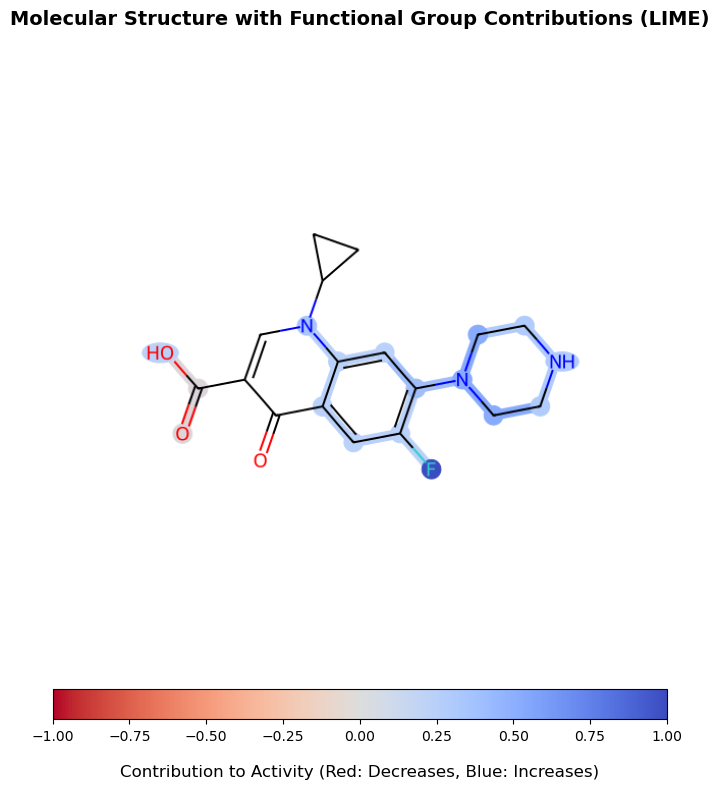

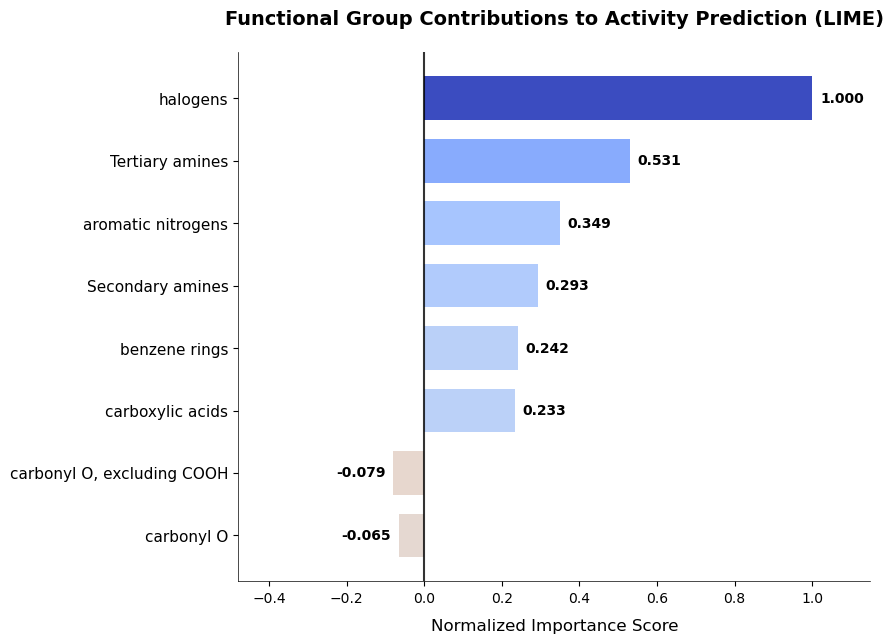


PREDICTION SUMMARY (LIME)
Active Probability: 0.639
Classification: Active
Confidence: 0.277

TOP CONTRIBUTING FUNCTIONAL GROUPS:
1. halogens: +0.013 (increases activity)
2. Tertiary amines: +0.007 (increases activity)
3. aromatic nitrogens: +0.004 (increases activity)
4. Secondary amines: +0.004 (increases activity)
5. benzene rings: +0.003 (increases activity)

Analysis complete! To analyze another molecule,
simply change the SMILES string above and run again.


In [3]:


# Alternative examples to try (uncomment one):
smiles = 'n1(C2CC2)cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)cc12'  # ciprofloxacin - 
#smiles ='FC1=C(C=C(N(C=C(C(OCC2=CC=C([N+]([O-])=O)C=C2)=O)C3=O)C4CC4)C3=C1)N5CCNCC5'  # prodrug 2 - 
#smiles = 'FC1=C(C=C(N(C=C(C(O)=O)C2=O)C3CC3)C2=C1)N4CCN(C(OCC5=CC=C(N=[N+]=[N-])C=C5)=O)CC4' #prodrug 4   

# 🎯 ANALYSIS SETTINGS (optional - you can leave these as default):
show_visualization = True  # Set to False if you only want text output
save_image = True  # Set to True to save molecule image
image_filename = 'molecule_analysis.png'  # Filename for saved image

# ⚡ RUN LIME ANALYSIS (Don't modify below this line)
# ====================================================
import traceback

try:
    print("Starting ensemble LIME analysis...")
    print("-" * 50)
    
    # Initialize explainer (this will use the setup from Cell 1)
    explainer = EnsembleRandomForestExplainer(
        best_models_path='best_models.json',
        model_checkpoints_dir='model_checkpoints',
        training_data_path='SA_FG_fragments.csv',
        fg_mapping_path='Functional_Group_mapping.txt',
        threshold=0.5
    )
    
    # Run LIME analysis
    save_path = image_filename if save_image else None
    explainer.visualize_explanation(
        smiles= smiles,
        show_plots=show_visualization,
        save_path=save_path
    )
    
except Exception as e:
    print(f"Error during analysis: {str(e)}")
    print("\nFull traceback:")
    traceback.print_exc()
    print("\nTroubleshooting tips:")
    print("1. Make sure you ran Cell 1 first")
    print("2. Check that all required files are in the correct directories")
    print("3. Verify your SMILES string is valid")
    print("4. Ensure all model checkpoint files exist in model_checkpoints/")

print("\n" + "="*60)
print("Analysis complete! To analyze another molecule,")
print("simply change the SMILES string above and run again.")
print("="*60)